Compare the controls to the measured susceptibility values of the blocks in order to understand the degree to which proposed low budget controls correlate with the observed susceptibility of the Pokec network.

Created 02/02/21

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import random
import itertools
import matplotlib
from scipy import stats
import math

from ising_block_level_influence import N_Block_sbm_class as NBlock
from ising_block_level_influence import projection_simplex as proj
from ising_block_level_influence import mean_field_IIM
from spatial_spin_monte_carlo import spatial_spin_monte_carlo as Spins
import Pokec_processing as  PokProc

from pokec_utils import *

### Read in processed data

This data has been generated using:

1. **make_Pokec_reduced_profiles.ipynb** - which then feeds data into:

2. The pre-processing script **'make_bratislava_graph_and_blocks.py'**.

In [2]:
graph = nx.read_graphml('Data/Bratislava_graph.graphml')
beta_c = Spins.crit_beta_sparse(graph)
bratislava_profiles = pd.read_csv("Data/bratislava_profiles.csv")
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
block_data = pd.read_csv('Data/block_info.csv',converters={'Block' : ast.literal_eval})
mean_block_ages = list(block_data['average_age'])
block_sizes = list(block_data['block_size'])
block_names = list(block_data['block_name'])
block_data['age_group'] = [ 'ages_' + k.split('_')[-1] for k in list(block_data['block_name'])]
block_data.head()

Computing critical temperature


,Unnamed: 0,block_name,block_size,average_age,age_group
0,0,Okolie_ages_1-17,1234,9.0,ages_1-17
1,1,Okolie_ages_18-21,1939,19.5,ages_18-21
2,2,Okolie_ages_22-28,3154,25.0,ages_22-28
3,3,Okolie_ages_29-112,3458,70.5,ages_29-112
4,4,Petrzalka_ages_1-17,1398,9.0,ages_1-17


In [3]:
def linear_field(x : np.ndarray,gradient :float) :
    return gradient*x
#Scale ages to [-1,1]:
rescaled_ages = [ (k-np.mean(mean_block_ages))/(max(mean_block_ages)-min(mean_block_ages)) for k in mean_block_ages ]

In [4]:
bratislava_profiles_indices = bratislava_profiles.reset_index()
groups = [ bratislava_profiles_indices.loc[bratislava_profiles_indices['block']==block] for block in block_names]
groups_node_ids = [list(k['index']) for k in groups]

In [7]:
def check_group(input_val,group_label) :
    if input_val == group_label :
        return 1.0
    else :
        return 0.0
    
def mean_and_se(values) :
    return f"{np.mean(values)} +/- {stats.sem(values)} "

#Seed the random number generators:
seed = 1
random.seed(seed)
np.random.seed(seed)

Field_Budget = 2500.0
T=10000
T_Burn = 2*300000
Samples = 15
sample_frac = 1.0 # for snapshot control
eval_data = pd.DataFrame()
control_data = pd.DataFrame()

init_sign=-1.0

beta_factor_vals = [8.0]
# grad_vals =  np.arange(1.0,11.0,1.0)
grad_vals=[0.0]

gradient=2.0

age_field = [linear_field(a,gradient) for a in rescaled_ages ]
age_field_map = {k:j for k,j in zip(list(block_data['age_group']),age_field)}

# Block MF setup:
coupling_graph = nx.convert_node_labels_to_integers(coupling_graph)
block_graph_ising_system = mean_field_IIM.mean_field_ising_system(coupling_graph,age_field)
block_graph_ising_system.gamma = 1.0
block_graph_ising_system.tol = 1E-5
block_graph_ising_system.max_mf_fp_iterations = 10000
block_graph_ising_system.mf_fp_init_state = init_sign*np.ones(len(block_sizes))
block_graph_ising_system.mf_fp_noisy = False

# Full graph Mf setup
background_field = np.asarray([age_field_map[k] for k in list(bratislava_profiles['age_group'])])
relab_graph = nx.relabel.convert_node_labels_to_integers(graph)
full_graph_ising_system = mean_field_IIM.mean_field_ising_system(relab_graph,background_field)
full_graph_ising_system.mf_fp_init_state = init_sign*np.ones(len(graph))
full_graph_ising_system.mf_fp_noisy = False

beta_factor=8.0


beta = beta_c*beta_factor

# Block gradient computation: 
m_block = block_graph_ising_system.mf_magnetization(age_field,beta)
mag_gradient = block_graph_ising_system.mf_magnetization_gradient(m_block, beta)
mag_grad_map = { i:j for i,j in zip(block_names,mag_gradient)}
block_names_list = list(bratislava_profiles['block'])
block_mf_gradient = np.asarray([mag_grad_map[k] for k in block_names_list])

print("block gradient computed")
# Full gradient computation: 
# m_full = full_graph_ising_system.mf_magnetization(background_field,beta)
# mag_grad_full = full_graph_ising_system.mf_sparse_magnetisation_gradient(m_full, beta)

# Compute the controls:
# H_full = np.sum(mag_grad_full)
H_block = np.sum(block_mf_gradient)
uniform_control = (Field_Budget / len(graph)) * np.ones(len(graph))
# mag_grad_full_at_field_budget = (Field_Budget/H_full)*mag_grad_full
mag_grad_block_at_field_budget = (Field_Budget/H_block)*block_mf_gradient
negative_cancelling_field = []
for field in background_field :
    if field < 0.0:
        negative_cancelling_field.append(-1.0*field)
    else:
        negative_cancelling_field.append(0.0)
negative_cancelling_field = np.asarray(negative_cancelling_field)
negative_cancelling_field = (Field_Budget/np.sum(negative_cancelling_field))*np.asarray(negative_cancelling_field) 
swing_voter_nodes = np.asarray([check_group(k,'ages_22-28') for k in list(bratislava_profiles['age_group']) ])
H_SV = np.sum(swing_voter_nodes)
swing_voter_control =  (Field_Budget/H_SV)*swing_voter_nodes

#Snapshot control
initial_state = init_sign*np.ones(len(graph))
block_snapshot = Run_MonteCarlo_Snapshot(relab_graph,groups_node_ids ,0, beta_factor,beta_c ,T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=background_field,initial_state=initial_state,frac_to_sample=sample_frac)
snapshot_gradient = [ (1.0-k**2) for k in block_snapshot ] 
snapshot_grad_map = { i:j for i,j in zip(block_names,snapshot_gradient)}
snapshot_influence = np.asarray([snapshot_grad_map[k] for k in block_names_list])
#Normalize:
H_snapshot = np.sum(snapshot_influence)
snapshot_influence = (Field_Budget/H_snapshot)*snapshot_influence


con_names = ['no con','unif','full','block','sv','nc','snapshot']
        
        

block gradient computed


In [8]:
initial_state

array([-1., -1., -1., ..., -1., -1., -1.])

In [30]:
T=300000
block_level_mags = Run_MonteCarlo_Block(relab_graph ,groups_node_ids,T, beta_factor,beta_c, T_Burn=0,addition_control=None,sampling_method="Metropolis",initial_state=initial_state,full_graph_field=background_field)

/home/matt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/matt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


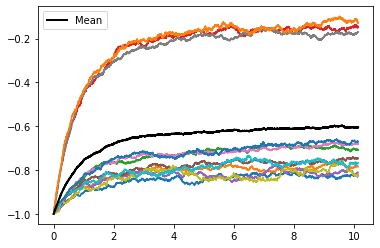

In [31]:
flips_per_spin=np.arange(0,T,1)/len(relab_graph)
for k in range(12) :
    plt.plot(flips_per_spin,np.asarray(block_level_mags).T[k])

plt.plot(flips_per_spin,np.mean(np.asarray(block_level_mags),axis=1),'k',lw=2.0,label='Mean')
plt.legend()

array([-0.82171799, -0.78545642, -0.70703868, -0.14690573, -0.80972818,
       -0.74738841, -0.68322507, -0.16923077, -0.81911263, -0.76669635,
       -0.67184943, -0.12903226])

In [32]:
cov_mat = np.cov(np.asarray(block_level_mags).T)
cov_mat.shape

(12, 12)

In [33]:
susceptibilities=np.sum(cov_mat,axis=1)
print(susceptibilities)

[0.03274504 0.03838554 0.05797218 0.14733319 0.03422563 0.04458036
 0.05855876 0.14185339 0.03588825 0.04328458 0.06105854 0.14662721]


Text(0, 0.5, 'Susceptibility')

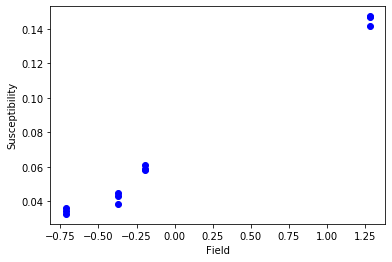

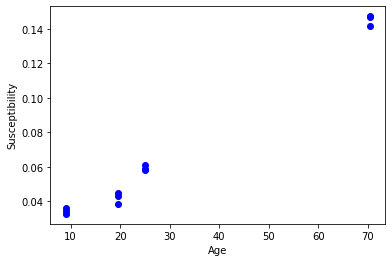

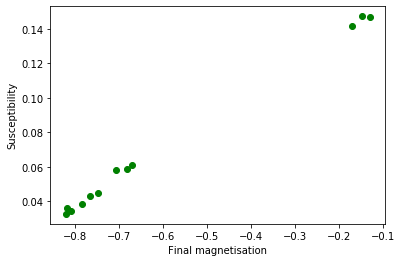

In [51]:
plt.figure(1)
plt.plot(age_field,susceptibilities,'bo')
plt.xlabel("Field")
plt.ylabel("Susceptibility")
# also compare magnetisation and susceptibility.

plt.figure(2)
plt.plot(mean_block_ages,susceptibilities,'bo')
plt.xlabel("Age")
plt.ylabel("Susceptibility")

plt.figure(3)
plt.plot(np.asarray(block_level_mags).T[:,-1],susceptibilities,'go')
plt.xlabel("Final magnetisation")
plt.ylabel("Susceptibility")

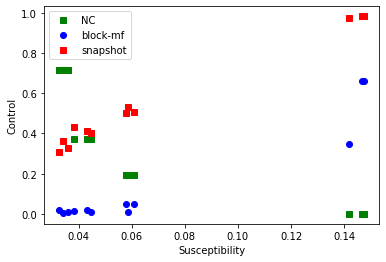

In [52]:
negative_cancelling_field = []
for field in age_field :
    if field < 0.0:
        negative_cancelling_field.append(-1.0*field)
    else:
        negative_cancelling_field.append(0.0)
        
plt.plot(susceptibilities,negative_cancelling_field,'gs',label='NC')
plt.plot(susceptibilities,mag_gradient,'bo',label='block-mf')
plt.plot(susceptibilities,snapshot_gradient,'rs',label='snapshot')
plt.ylabel("Control")
plt.xlabel("Susceptibility")

plt.legend()

In [ ]:
for s in tqdm.tqdm_notebook( range(Samples) )  : 

            initial_state = init_sign*np.ones(len(graph))
            no_control = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=background_field,initial_state=initial_state)

            initial_state = init_sign*np.ones(len(graph))
            unif_control_field = np.asarray([i+j for i,j in zip(uniform_control,background_field)])
            unif_control = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=unif_control_field,initial_state=initial_state)

            initial_state = init_sign*np.ones(len(graph))
            full_sus_control_field = np.asarray([i+j for i,j in zip(mag_grad_full_at_field_budget,background_field)])
            full_sus_control_mags = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=full_sus_control_field,initial_state=initial_state)

            initial_state = init_sign*np.ones(len(graph))
            block_sus_control_field = np.asarray([i+j for i,j in zip(mag_grad_block_at_field_budget,background_field)])
            block_sus_control_mags = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=block_sus_control_field ,initial_state=initial_state)

            initial_state = init_sign*np.ones(len(graph))
            sv_control_field = np.asarray([i+j for i,j in zip(swing_voter_control,background_field)])
            sv_control_mags = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=sv_control_field  ,initial_state=initial_state)

            initial_state = init_sign*np.ones(len(graph))
            nc_control_field = np.asarray([i+j for i,j in zip(negative_cancelling_field,background_field)])
            nc_control_mags = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=nc_control_field  ,initial_state=initial_state)

            initial_state = init_sign*np.ones(len(graph))
            snapshot_control_field = np.asarray([i+j for i,j in zip(snapshot_influence,background_field)])
            snapshot_control_mags = Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=snapshot_control_field  ,initial_state=initial_state)

            
            means=[]
            ses=[]
            #Loop in same order as cont_names
            control_list = [no_control,unif_control,full_sus_control_mags,block_sus_control_mags,sv_control_mags,nc_control_mags,snapshot_control_mags]
            for k in control_list :
                print(mean_and_se(k))
                means.append(np.mean(k))
                ses.append(stats.sem(k))

            eval_data = eval_data.append(pd.DataFrame({'control':con_names,'magnetisation':means,'mag_se':ses,'beta_factor':beta_factor*np.ones(len(means)),'gradient':gradient*np.ones(len(means))}))
            #eval_data.to_csv("Data/Pokec_control_eval_data_positive.csv")
            #eval_data.to_csv("Data/Pokec_control_eval_data_no_field.csv")